# Quick graph creation

#### Libraries

In [1]:
import spacy
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)

from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

2022-01-20 09:46:22.052097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 09:46:22.052172: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/becode/.local/lib/python3.10/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
nlp = spacy.load('en_core_web_sm')
doc1 = nlp("The 22-year-old recently won ATP Challenger tournament.")
for tok in doc1:
  print(tok.text, "...", tok.dep_)

The ... det
22 ... nummod
- ... punct
year ... npadvmod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


We wanted to extract “22-year-old” instead.

The rule can be something like this — extract the subject/object along with its modifiers and also extract the punctuation marks between them.
In short, we will use dependency parsing to extract entities.

#### Extract Relations

Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

In [3]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


To extract the relation, we have to find the ROOT of the sentence (which is also the verb of the sentence). Hence, the relation extracted from this sentence would be “won”.

#### Build a Knowledge Graph from Text Data

The following dataset exists of 4,300 sentences from over 500 Wikipedia articles. Each of these sentences contains exactly two entities – one subject and one object. 

In [15]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("../../assets/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [16]:
candidate_sentences

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,and le parisien gave the film their highest five-star rating.
4315,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,"its predecessor was the dutch historical film archive, founded in 1946."


Inspect a few sentences

In [18]:
candidate_sentences.sample(5)

,sentence
2880,stated that the film would be based on the 2012-2013 shazam!
2130,the peasants is a polish historical film directed by jan rybkowski.
3339,"although mostly used by kodak cameras, it became very popular."
586,james mangold was later hired to direct the film.
2902,"in the novel, elio and oliver reunite 15 years later when oliver is married."


check the subject and object of one of these sentences. Ideally, there should be one subject and one object in the sentence

In [19]:
doc = nlp("Mitsubishi Heavy Industries Ltd MITH.T  (MHI) and C. Itoh and Co Ltd CITT.T have decided to sell  their combined 65 pct stake in Indonesias Pt Triguna Utama  Machinery Industries to Caterpillar")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Mitsubishi ... compound
Heavy ... compound
Industries ... compound
Ltd ... nsubj
MITH.T ... compound
  ... dep
( ... punct
MHI ... appos
) ... punct
and ... cc
C. ... compound
Itoh ... conj
and ... cc
Co ... compound
Ltd ... compound
CITT.T ... conj
have ... aux
decided ... ROOT
to ... aux
sell ... xcomp
  ... dep
their ... poss
combined ... amod
65 ... nummod
pct ... compound
stake ... dobj
in ... prep
Indonesias ... compound
Pt ... compound
Triguna ... compound
Utama ... nmod
  ... dep
Machinery ... compound
Industries ... pobj
to ... prep
Caterpillar ... pobj


 There is only one subject (‘process’) and only one object (‘standard’). You can check for other sentences in a similar manner.

#### Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. 

However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

The function below is used to extract the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above. 

In [20]:
sent= "The 22-year-old recently won ATP Challenger tournament."

In [21]:
def get_entities(sent):
    
    
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""
    
###########################
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
                    
            
    # check: token is a modifier or not
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
    
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
            modifier = prv_tok_text + " "+ tok.text
            
            
        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""
            
        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text
            
        ## chunk 5  
        # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
  ##    ###########################################################

    return [ent1.strip(), ent2.strip()]

In [22]:
get_entities(sent)

['year  old', 'Challenger tournament ATP Challenger tournament']

we can use this function to extract these entity pairs for all the sentences in our data

In [24]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████████████████████████████████| 4318/4318 [00:36<00:00, 116.73it/s]


In [25]:
entity_pairs

[['connie', 'own'],
 ['later  scream', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['', 'cult wails cult him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie c. mackenzie', 'craig vincent craig cast'],
 ['di francia craig di francia', 'action bronson action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film'],
 ['we', 'tests'],
 ['', 'sales rights sales rights'],
 ['robbie robertson musician robbie robertson', 'soundtrack'],
 ['it', 'music tracks music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'eberhardt portrays eberhardt portrays'],
 ['singer', 'men'],
 ['last  which', 'penn'],
 ['jessica chastain jessica chastain', 'same  character'],
 ['mauro fiore mauro fiore', 'cinematographer'],
 ['filming', 'october'],
 ['soundtrack', 'digitally  june'],
 ['album', 'digitally  august'],
 ['film', 'motion pictures studios motion pictures'],
 ['it', '1

clean the entity pairs..

#### Relation / Predicate Extraction

This is going to be a very interesting aspect of this article. Our hypothesis is that the predicate is actually the main verb in a sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching

In [27]:
sent= candidate_sentences["sentence"]

In [35]:
def get_relation(entity_pairs):
    
    doc = nlp(sent)
    
    # Matcher class object 
    matcher = Matcher(nlp.vocab)
    
    #define the pattern 
    pattern = [#{'DEP':'ROOT'}, 
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},  
               {'POS':'VERB'#,'OP':"?"
               }] 
    
    matcher.add("matching_1", [pattern]) 
    matches = matcher(doc)
    
    k= len(matches) - 1
    
    span= doc[matches[k][1]:matches[k][2]]
    rel= [doc[matches[k][1]: matches[k][2]] for k in range(len(matches))]
    
    return rel

In [36]:
get_relation(entity_pairs)

ValueError: [E866] Expected a string or 'Doc' as input, but got: <class 'pandas.core.series.Series'>.

In [46]:
#get_relation("John completed the task")

In [55]:
relations = [get_relation(i) for i in tqdm(entity_pairs)]

100%|████████████████████████████████████| 10788/10788 [01:42<00:00, 105.52it/s]


In [13]:
pd.Series(relations).value_counts()[:50]

NameError: name 'relations' is not defined

#### Build a Knowledge Graph

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates

In [58]:
entity_pairs

[['Michael Smith Representative Michael Smith', 'week International dispute'],
 ['government', 'further paper details'],
 ['21 hour they', 'hour basis hour oil'],
 ['seven  Products', '57 export pct'],
 ['Indonesian export exports', 'bank   bank figures'],
 ['it', 'shipping movements shipping movements'],
 ['Total 6.87 membership', 'exchange'],
 ['shipment', 'April'],
 ['ore   ore capacity', 'first treatment mid-1988'],
 ['strategy', 'that'],
 ['thirds majority thirds majority', 'extension'],
 ['dealers', 'call money call money'],
 ['ore tonnage ore tonnage', 'least operations 1993'],
 ['further  It', 'further  details'],
 ['Farm products U.S. Farm issues', 'same  table'],
 ['pct stake pct it', 'enlarged dividend capital'],
 ['5.8 timber Interest', 'mln debit mln debit'],
 ['Partly bankers offsetting', 'mln  system'],
 ['proper  Kim', 'proper  level'],
 ['late Alberta statement', 'late Alberta 1989'],
 ['year Western It', 'gold project gold project'],
 ['recent industry data', 'pct ris

In [37]:
## extract subject
#source = [i[0] for i in entity_pairs]
#
## extract object
#target = [i[1] for i in entity_pairs]
#
#kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

NameError: name 'relations' is not defined

In [41]:
pd.Series(entity_pairs).value_counts()[:50]

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'
  0%|                                                  | 0/4318 [01:44<?, ?it/s]


[, ]                                                                43
[i, it]                                                             10
[film, box office box office]                                        7
[you, it]                                                            5
[award, ]                                                            5
[certificate awards certificate awards, film awards film awards]     5
[she, him]                                                           5
[film, may]                                                          5
[he, ]                                                               5
[principal  photography, august]                                     5
[it, film festival film festival]                                    5
[last  release, year]                                                4
[you, me]                                                            4
[film, mixed  reviews]                                               4
[, mov

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.
It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [60]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

#### plot

In [61]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

KeyboardInterrupt: 

<Figure size 864x864 with 0 Axes>

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

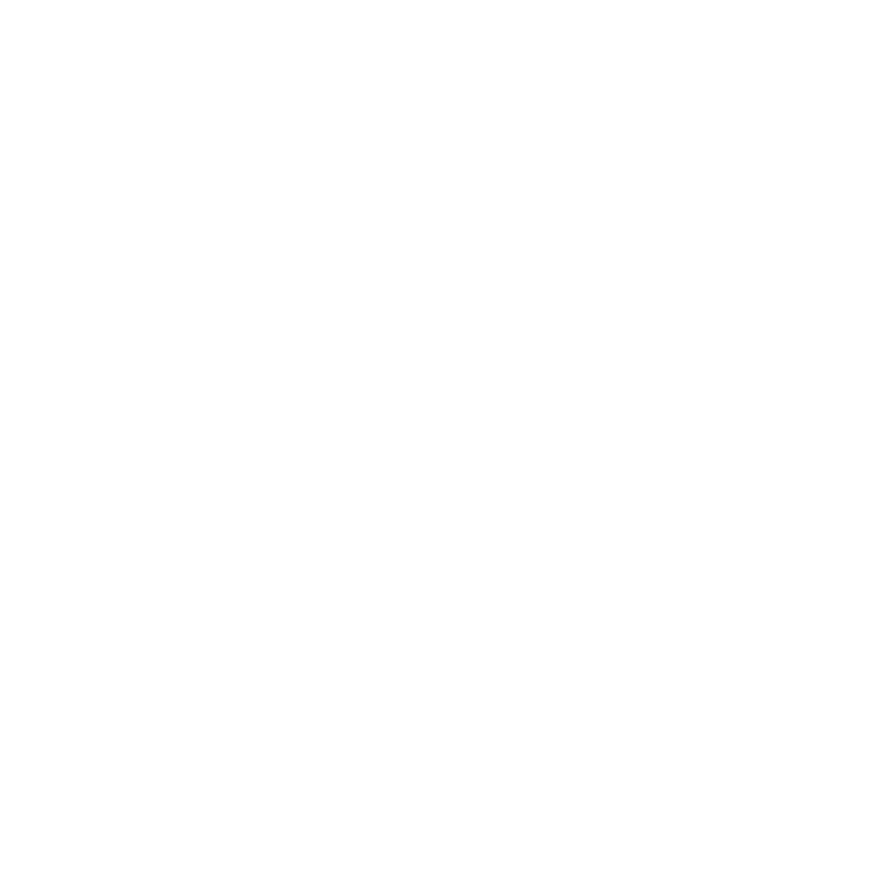

In [62]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

Let’s check out a few more relations.

Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation

In [23]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

NameError: name 'kg_df' is not defined

This knowledge graph is giving us some extraordinary information. Guys like Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “released in”

In [24]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

NameError: name 'kg_df' is not defined

#### Resources


https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/